## Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import norm, gamma
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from joblib import Parallel, delayed
from scipy.optimize import minimize
from scipy.special import ndtr
import time
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
ignore_warnings(category=ConvergenceWarning)
import matplotlib.pyplot as plt

## Gradient computation in GPR (Sklearn)

In [23]:
# In the original GPR in sklearn, derivatives of mean/std dev. is not provided.
# Hence, once we fit the GPR, we recompute the derivatives using the available attributes.

#########################################################
### derivatives of rbf kernel (new_point, train_set)
#########################################################
def rbf_kernel_derivative(x, x_prime, l):
    sqdist = np.sum((x - x_prime)**2)
    derivative = -(x - x_prime) / (l**2) * np.exp(-0.5 * sqdist / (l**2))
    return derivative

#########################################################
### derivatives of gpr mean/std. deviation
#########################################################
def grad_compute(x, model):
    l = model.kernel_.length_scale
    x = np.atleast_2d(x)

    K_new_train = model.kernel_(x, model.X_train_)
    K_train_new = K_new_train.T
    std = model.predict(x, return_std=True)[1]

    diff = x[:, np.newaxis, :] - model.X_train_[np.newaxis, :, :]
    grad_K_new_train = -diff / l**2 * K_new_train[:, :, np.newaxis]

    # Good reference for computing (A^-1) given cholskey decomposition of the matrix (A = LL^T)
    # https://math.stackexchange.com/questions/4441306/best-way-to-compute-a-1-when-the-cholesky-decomposition-a-llt-is-known
    K_X_X_inv = np.linalg.solve(model.L_.T, np.linalg.solve(model.L_, np.eye(model.L_.shape[0])))

    term1 = (K_X_X_inv @ model.y_train_)
    term2 = K_X_X_inv @ K_train_new
    term3 = K_new_train @ K_X_X_inv

    mean_grad = np.zeros(x.shape)
    sigma_grad = np.zeros(x.shape)
    for d in range(x.shape[1]):
        grad_dim = grad_K_new_train[:, :, d].reshape(x.shape[0], -1)
        mean_grad[:, d] = grad_dim @ term1
        sigma_grad[:, d] = -0.5 / std * (
            grad_dim @ term2 + term3 @ grad_dim.T
        ).diagonal()

    return mean_grad[0], sigma_grad[0]

## Acquisition functions

In [24]:
# Root-finding variants are named with ~rf.
# These acqusition functions return value & gradient.

#########################################################
### Upper Confidence Bound
#########################################################
lmbda = 0.1
def ucb(X, model):
    mu, sigma = model.predict(np.atleast_2d(X), return_std=True)
    mu_grad, sigma_grad = grad_compute(X, model)    
    
    return mu + lmbda * sigma, mu_grad + lmbda * sigma_grad


def ucbrf(X, model):
    mu, sigma = model.predict(np.atleast_2d(X), return_std=True)
    mu_grad, sigma_grad = grad_compute(X, model)   
    
    if mu >= 0:
        return abs(mu) + lmbda * sigma, mu_grad + lmbda * sigma_grad
    else:
        return abs(mu) + lmbda * sigma, -mu_grad + lmbda * sigma_grad
    
#########################################################
### Probability of Improvement
#########################################################
def pi(X, model):
    mu, sigma = model.predict(np.atleast_2d(X), return_std=True)
    mu_sample_opt = np.abs(model.y_train_).min()
    mu_grad, sigma_grad = grad_compute(X, model)    

    z_ub = (mu_sample_opt - mu) / sigma

    cdf_z_ub = ndtr(z_ub)
    pdf_z_ub = norm.pdf(z_ub)
    
    pi = cdf_z_ub
    
    pi_grad = pdf_z_ub * (-mu_grad * sigma - (mu_sample_opt - mu) * sigma_grad) / (sigma**2)
    
    return -pi, -pi_grad


def pirf(X, model):
    mu, sigma = model.predict(np.atleast_2d(X), return_std=True)
    mu_sample_opt = np.abs(model.y_train_).min()
    mu_grad, sigma_grad = grad_compute(X, model)

    z_lb = (-mu_sample_opt - mu) / sigma
    z_ub = (mu_sample_opt - mu) / sigma
    
    cdf_z_lb = ndtr(z_lb)
    cdf_z_ub = ndtr(z_ub)
    
    pdf_z_lb = norm.pdf(z_lb)
    pdf_z_ub = norm.pdf(z_ub)
    
    pirf = cdf_z_ub - cdf_z_lb
    
    z_ub_grad = (-mu_grad * sigma - (mu_sample_opt - mu) * sigma_grad) / (sigma ** 2)
    z_lb_grad = (-mu_grad * sigma + (mu_sample_opt + mu) * sigma_grad) / (sigma ** 2)
    
    pirf_grad = pdf_z_ub * z_ub_grad - pdf_z_lb * z_lb_grad

    return -pirf, -pirf_grad


#########################################################
### Expected Improvement
#########################################################
def ei(X, model):
    mu, sigma = model.predict(np.atleast_2d(X), return_std=True)
    mu_sample_opt = np.abs(model.y_train_).min()
    mu_grad, sigma_grad = grad_compute(X, model)

    z_ub = (mu_sample_opt - mu) / sigma
    
    cdf_z_ub = ndtr(z_ub)
    pdf_z_ub = norm.pdf(z_ub)
    
    ei = (mu_sample_opt - mu) * cdf_z_ub + sigma * pdf_z_ub
    
    z_ub_grad = (-mu_grad * sigma - (mu_sample_opt - mu) * sigma_grad) / (sigma ** 2)
    
    ei_grad = - mu_grad * cdf_z_ub +(mu_sample_opt - mu) * z_ub_grad * pdf_z_ub + \
              sigma_grad * pdf_z_ub - \
              sigma * (z_ub_grad*z_ub/((np.pi*2)**0.5)*np.exp(-z_ub**2/2))
        
    return -ei, -ei_grad


def eirf(X, model):
    mu, sigma = model.predict(np.atleast_2d(X), return_std=True)
    mu_sample_opt = np.abs(model.y_train_).min()
    mu_grad, sigma_grad = grad_compute(X, model)

    z_lb = (-mu_sample_opt - mu) / sigma
    z_thr = (-mu) / sigma
    z_ub = (mu_sample_opt - mu) / sigma

    pdf_z_lb = norm._pdf(z_lb)
    pdf_z_thr = norm._pdf(z_thr)
    pdf_z_ub = norm._pdf(z_ub)

    cdf_z_lb = ndtr(z_lb)
    cdf_z_thr = ndtr(z_thr)
    cdf_z_ub = ndtr(z_ub)
    
    z_ub_grad = (-mu_grad * sigma - (mu_sample_opt - mu) * sigma_grad) / (sigma ** 2)
    z_thr_grad = (-mu_grad * sigma - ( - mu) * sigma_grad) / (sigma ** 2)
    z_lb_grad = (-mu_grad * sigma - (-mu_sample_opt - mu) * sigma_grad) / (sigma ** 2)

    eirf = np.abs(mu_sample_opt) * (cdf_z_ub - cdf_z_lb) + \
         mu * (2 * cdf_z_thr - cdf_z_lb - cdf_z_ub) - \
         sigma * (2 * pdf_z_thr - pdf_z_ub - pdf_z_lb)
    
    eirf_grad = mu_sample_opt * (z_ub_grad * pdf_z_ub - z_lb_grad * pdf_z_lb) + \
                    mu_grad * (2 * cdf_z_thr - cdf_z_lb - cdf_z_ub) + \
                    mu * (2 * z_thr_grad * pdf_z_thr - z_lb_grad * pdf_z_lb - z_ub_grad * pdf_z_ub) - \
                    sigma_grad * (2 * pdf_z_thr - pdf_z_lb - pdf_z_ub) - \
                    sigma * (-2 * z_thr_grad * z_thr / ((np.pi * 2) ** 0.5) * np.exp(-z_thr ** 2 / 2) + z_lb_grad * z_lb / ((np.pi * 2) ** 0.5) * np.exp(-z_lb ** 2 / 2) + z_ub_grad * z_ub / ((np.pi * 2) ** 0.5) * np.exp(-z_ub ** 2 / 2))
    
    return -eirf, -eirf_grad

## Reduced Search Space (RSS)

In [25]:
# RSS returns the interval that is expected to have roots
# which involves actual root (from targeting function) 
# and maximum acquisition value point (from GP prior)

#########################################################
### Reduced Search Space
#########################################################
def rss(X, y):

    if len(y) < 2:
        return None

    X = np.atleast_2d(X)
    if X.shape[0] == 1:
        X = X.T

    y = np.array(y).flatten()

    indices = np.where(np.triu(np.outer(y, y) < 0))

    if len(indices[0]) != 0:
        hypervolumes = []

        for i0 in range(len(indices[0])):
            ind0 = indices[0][i0]
            ind1 = indices[1][i0]
                
            # Compute hypervolume
            hypervolumes.append(np.prod(np.abs(X[ind0] - X[ind1])) * abs(y[ind0] - y[ind1]))
        
        # Return the smallest hypervolume
        opt_indices = np.argmin(hypervolumes)

        return indices[0][opt_indices], indices[1][opt_indices]

    else:
        return None

## Parallel setup

In [26]:
# **Note** 
# When running this file in the Google colab (with basic)
# as the number of core is only 2, this incurs some problem in the joblib (parallel library) setting.
# Thus, when using in the google colab, modify the code ("results") in the ("propose_location") with manual for_loop (provided)
# if you are running in your local computer, you don't need to change anything.

# In this parallel setting, the default setting is 50-starting strategy
# with L-BFGS-B to maximize the acquisition function in BO

#########################################################
### Single minimization attempt
#########################################################
def minimization(x0, acquisition, model, bounds):
    res = minimize(lambda x: acquisition(x, model), jac = True,
                   x0=x0, bounds=bounds, method='L-BFGS-B',
                   options={"disp": False, "maxiter": 10})

    return res

#########################################################
### Maximizing acquisition function with parallel run
#########################################################
def propose_location(acquisition, model, bounds, i0, n_restarts=50):
    dim = len(bounds)

    if i0 == 3:
        x_list, y_list = model.X_train_, model.y_train_
        interval = rss(x_list, y_list)
    else:
        interval = None

    if interval is not None:
        x_range_lb2 = np.min([x_list[interval[0]], x_list[interval[1]]], axis=0)
        x_range_ub2 = np.max([x_list[interval[0]], x_list[interval[1]]], axis=0)
    else:
        x_range_lb2 = np.array([dimension[0] for dimension in bounds])
        x_range_ub2 = np.array([dimension[1] for dimension in bounds])

    x0s = np.random.uniform(x_range_lb2, x_range_ub2, size=(n_restarts, dim))

    if dim == 1:
        if np.isscalar(x_range_lb2) and np.isscalar(x_range_ub2):
            bounds = [(x_range_lb2, x_range_ub2)]
        else:
            bounds = [(x_range_lb2[0], x_range_ub2[0])]
    else:
        bounds = list(zip(x_range_lb2, x_range_ub2))

    
    results = Parallel(n_jobs = -1)(delayed(minimization)(x0, acquisition, model, bounds) for x0 in x0s)
    
    ## change to this when using google colab
    #results = [single_minimization_attempt(x0, acquisition, model, bounds) for x0 in x0s] 

    min_val = np.inf
    min_x = None
    for res in results:
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x   

## Experiment (true function)

In [27]:
#########################################################
### Modified Himmelblau function
#########################################################
def true(x):    
    x,y, = x
    return np.log2((x**2 + y - 5)**2 + (x + y**2 - 3)**2) - 1

bounds = [(-5,5), (-5,5)]
X_init = np.array([[2.1, 1.1]])

In [28]:
#########################################################
### M/M/1 queue
#########################################################
def simulate_mmn_queue(x, num_servers = 1, num_people=1000):
    mu_rate = 5
    inter_arrival_times = np.random.exponential(1/x, num_people)
    service_times = np.random.exponential(1/mu_rate, num_people)
    arrival_times = np.cumsum(inter_arrival_times)

    next_available_times = np.zeros(num_servers)

    departure_times = []

    for i in range(num_people):

        idx_server = np.argmin(next_available_times)
        arrival_time = max(arrival_times[i], next_available_times[idx_server])
        departure_time = arrival_time + service_times[i]
        next_available_times[idx_server] = departure_time
        departure_times.append(departure_time)

    departure_times = np.sort(departure_times)
    waiting_times_system = departure_times - arrival_times[:len(departure_times)]
    waiting_times_queue = waiting_times_system - service_times[:len(departure_times)]

    return np.mean(waiting_times_queue + waiting_times_system)


true_lambda = 4
rw_ = simulate_mmn_queue(true_lambda)

def true(x):
    global rw_
    
    dt_list = []
    for _ in range(1):
        dt_ = simulate_mmn_queue(x)
        dt_list.append(dt_)
    
    return rw_ - np.mean(dt_list)

bounds = [(1, 10)]
X_init = np.array([[3]])

## Experiment (run)

In [29]:
# To run the experiment, run the "true function" cell first (Himmelblau or MM1) 
# and then run this cell

num_mac = 10
samples = 10

#########################################################
### Experiment
#########################################################
@ignore_warnings(category=ConvergenceWarning)
def optimize(i0, i1, bounds, samples, method):

    model = GaussianProcessRegressor(n_restarts_optimizer=10, normalize_y=False, kernel = RBF())

    np.random.seed(i1)
    dim = len(bounds) 
    
    if i0 in [0,3]:
        Y_init = np.array(true(np.ravel(X_init))).reshape(-1, 1)
    elif i0 in [1]:
        Y_init = abs(np.array(true(np.ravel(X_init))).reshape(-1, 1))
    elif i0 in [2]:
        Y_init = np.array(true(np.ravel(X_init))).reshape(-1, 1)**2

    model.fit(X_init, Y_init)

    for i1 in range(samples-1):
        if i0 in [0,3]:
            if method == 0:
                X_next = propose_location(ucbrf, model, bounds, i0)
            if method == 1:
                X_next = propose_location(pirf, model, bounds, i0)
            if method == 2:
                X_next = propose_location(eirf, model, bounds, i0)
        if i0 in [1,2]:
            if method == 0:
                X_next = propose_location(ucb, model, bounds, i0)
            if method == 1:
                X_next = propose_location(pi, model, bounds, i0)
            if method == 2:
                X_next = propose_location(ei, model, bounds, i0)

        if i0 in [0,3]:
            Y_next = np.array(true(np.ravel(X_next))).reshape(-1, 1)
        if i0 in [1]:
            Y_next = abs(np.array(true(np.ravel(X_next))).reshape(-1, 1))
        if i0 in [2]:
            Y_next = np.array(true(np.ravel(X_next))).reshape(-1, 1)**2
            
        model.fit(np.vstack([model.X_train_, X_next]), np.vstack([model.y_train_, Y_next]))

    
    temp = [true(x) for x in model.X_train_]
    temp = abs(np.array(temp))
    temp = [temp[:i0+1].min() for i0 in range(len(temp))]

    return temp, model.X_train_


results = Parallel(n_jobs=-1)(delayed(optimize)(i0, i1, bounds, samples, ii)
                                  for ii in tqdm(range(3), leave = False) 
                                  for i0 in tqdm(range(4), leave = False) 
                                  for i1 in range(num_mac))

performance = [result[0] for result in results]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## Experiment (result analysis)

C:\Users\jeon\AppData\Local\Temp\ipykernel_12172\3080918945.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


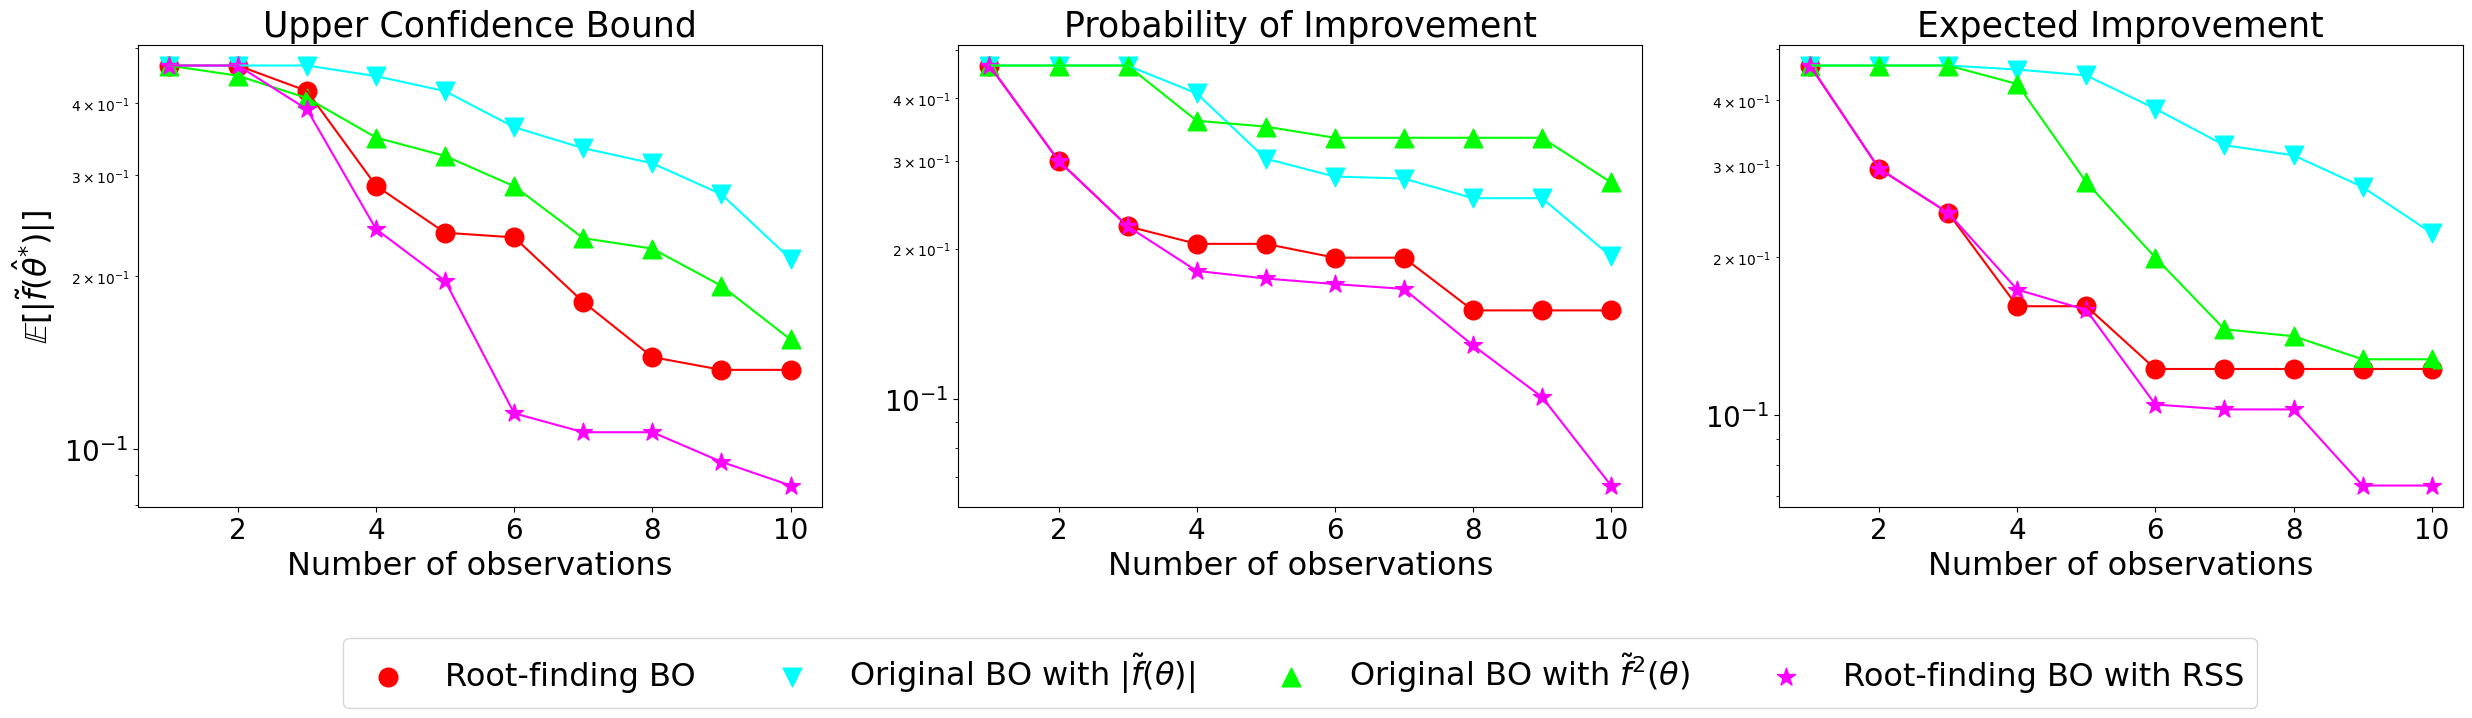

In [30]:
plt.figure(figsize=(30, 6))

methods = [r"Root-finding BO", r"Original BO with $|\tilde{f}(\theta)|$",
           r"Original BO with $\tilde{f}^2(\theta)$", r"Root-finding BO with RSS"]
colors = ["red", "cyan", "lime", "magenta"]
linestyles = ["-", "-", "-", "-"]
markers = ["o", "v", "^", "*"]
titles = ["Upper Confidence Bound", "Probability of Improvement", "Expected Improvement"]

performances = np.array(performance).reshape(3,4,num_mac,samples)

for i0 in range(3):
    plt.subplot(1,3,i0+1)
    for i1 in range(4):
        means = performances[i0,i1,:,:].mean(axis = 0)
        plt.scatter(range(1, samples + 1),
                    means,
                    marker = markers[i1],
                    label = methods[i1],
                    facecolors = colors[i1],
                    edgecolor = colors[i1],
                    s = 180)
        
        plt.plot(range(1, samples + 1), means, linestyle = linestyles[i1], color = colors[i1])
        
    plt.title(titles[i0], fontsize=25)
    plt.xlabel("Number of observations", fontsize=23)
    if i0 == 0:
        plt.ylabel(r"$\mathbb{E}[|\tilde{f}(\hat{\theta}^{*})|]$", fontsize=23)
    
    plt.yscale("log")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.legend(fontsize=23, loc='upper center', ncol=4, bbox_to_anchor=(-0.7, -0.25))
plt.tight_layout()
plt.show()

## Side experiment (sampling trace of Himmelblau's function)

In [31]:
# Change the number of samples and starting point
samples = 10
X_init = np.array([[2.05, 1.05]])

#########################################################
### Modified Himmelblau function
#########################################################
def true(x):    
    x,y, = x
    return np.log2((x**2 + y - 5)**2 + (x + y**2 - 3)**2) - 1

bounds = [(-5,5), (-5,5)]

#########################################################
### Run side experiment
#########################################################
results = Parallel(n_jobs=-1)(delayed(optimize)(i0, i1, bounds, samples, ii)
                                  for ii in tqdm(range(3), leave = False) 
                                  for i0 in tqdm(range(4), leave = False) 
                                  for i1 in range(1))

performance = [result[1] for result in results]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

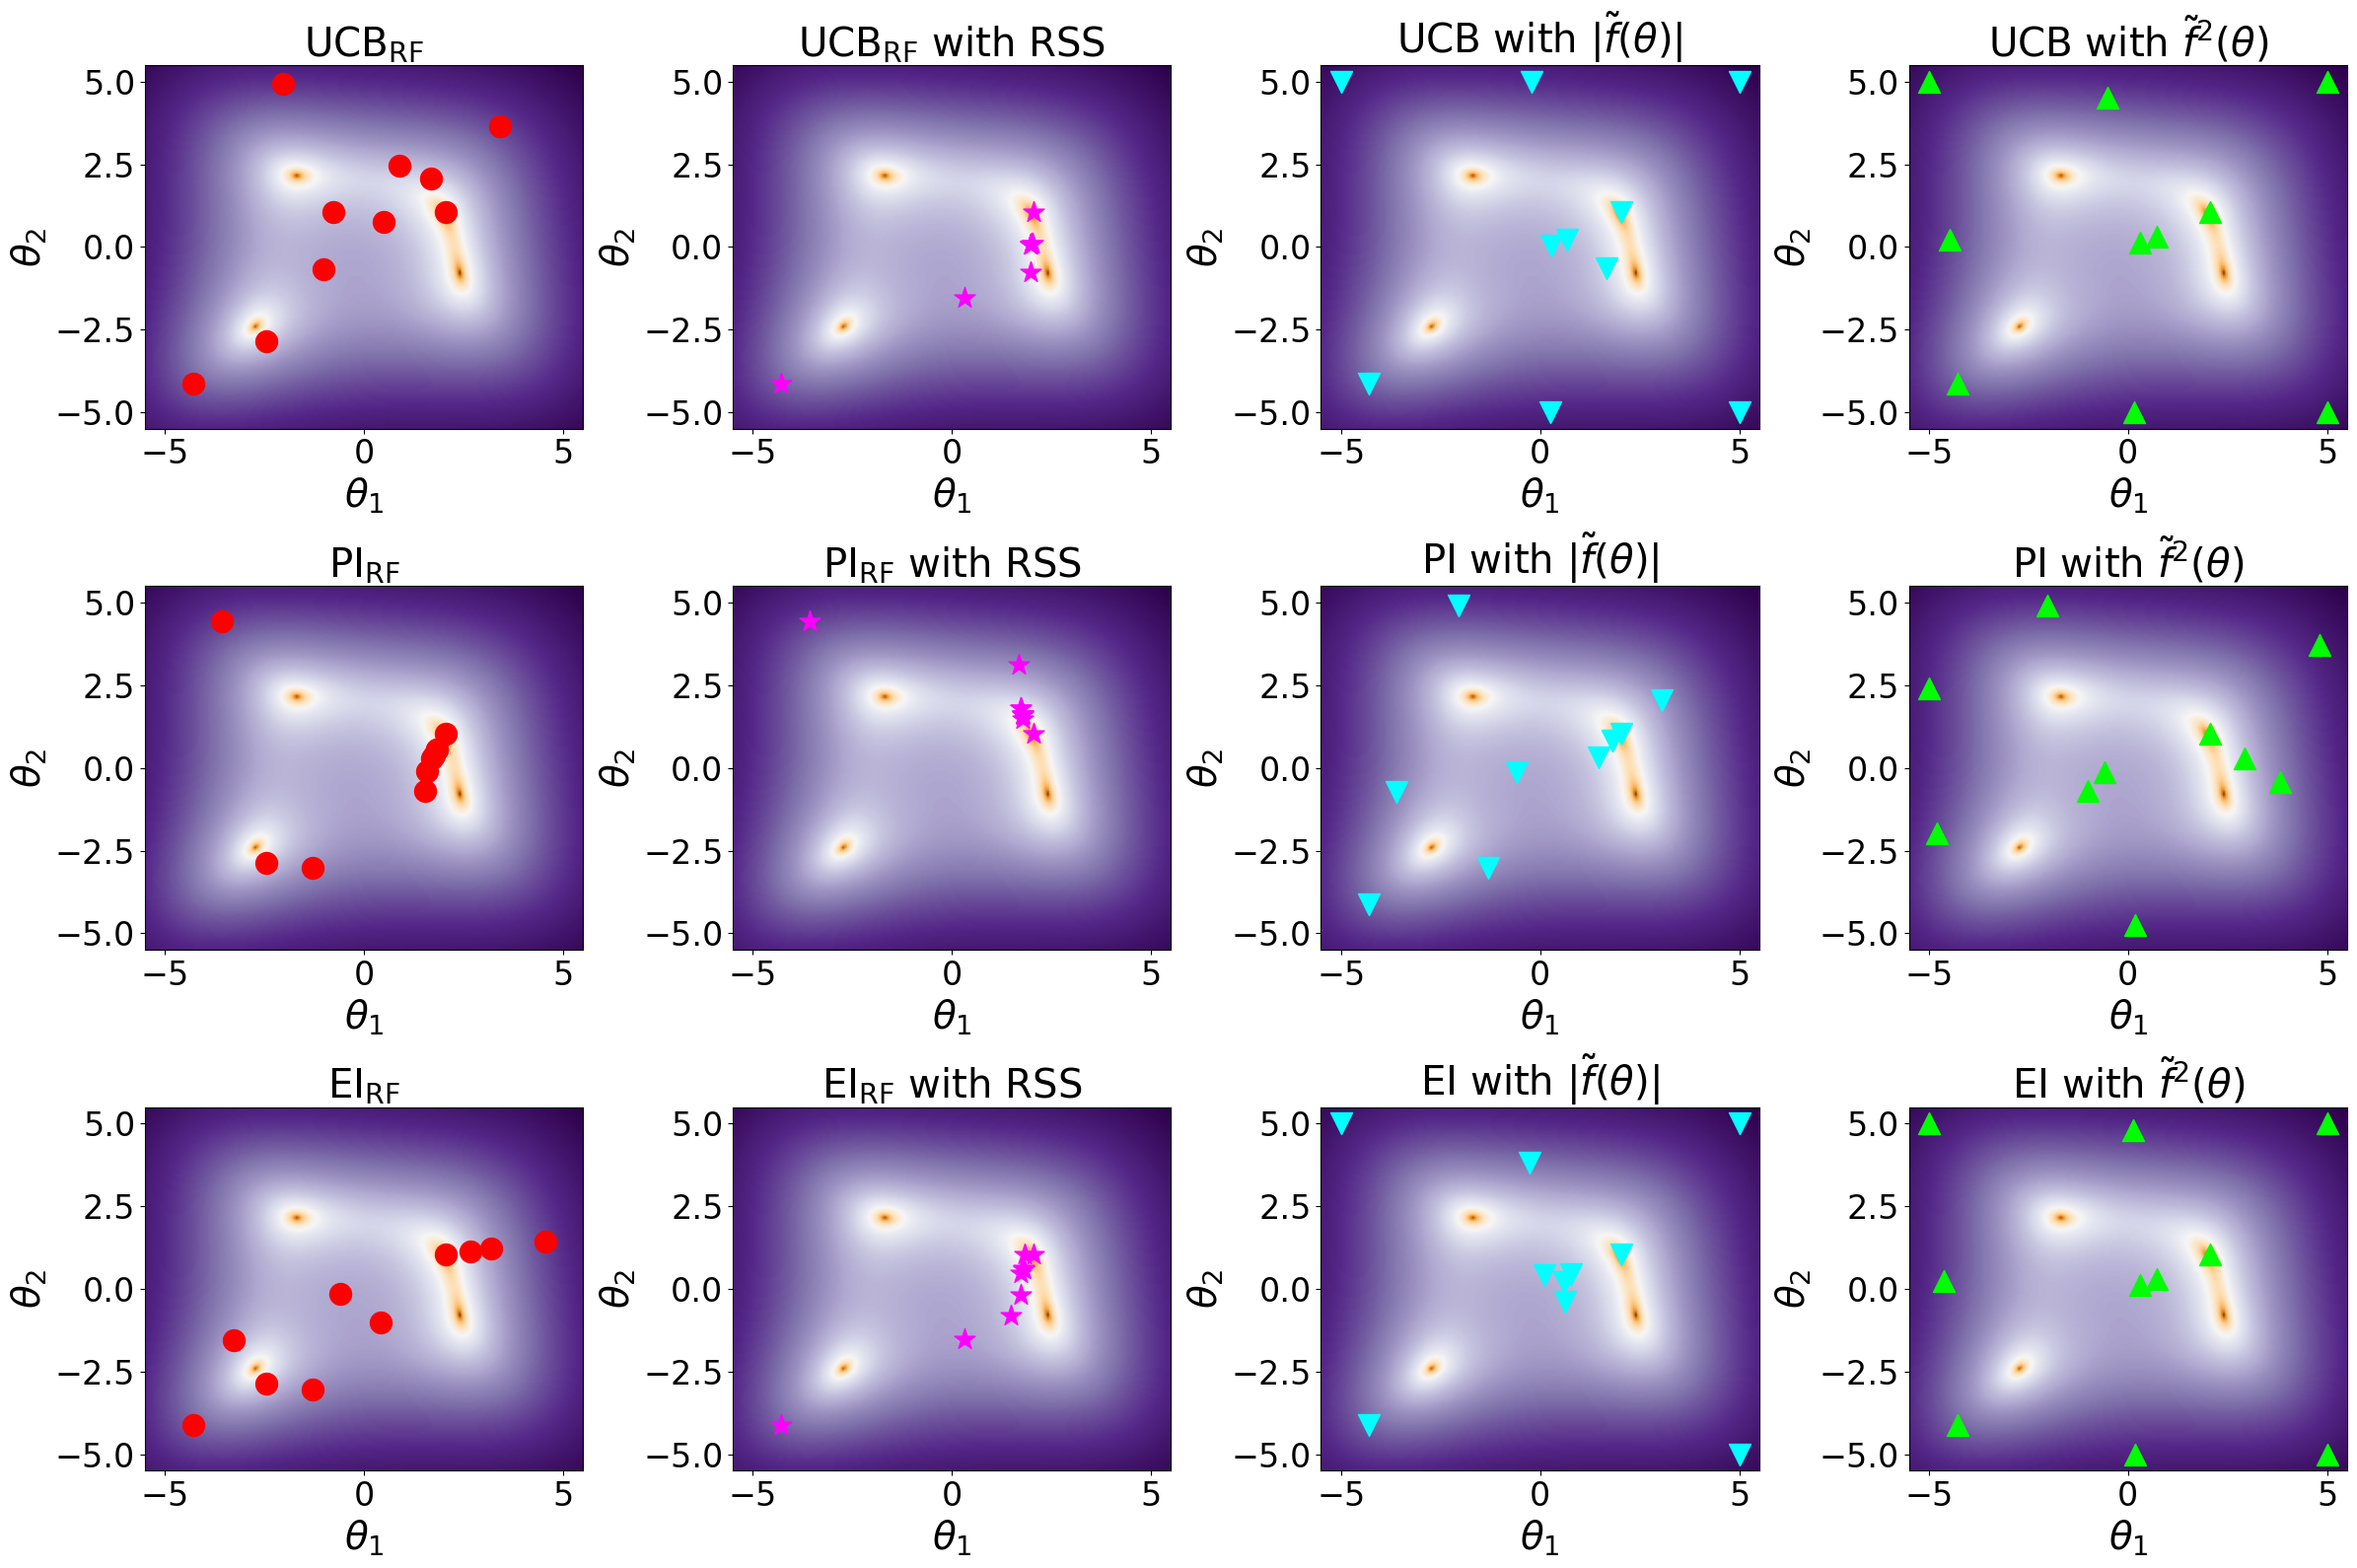

In [32]:
datas = np.array(performance).reshape(3, 4, 1, samples, 2)

num_points = 200
grid = [np.linspace(dimension[0]-0.5, dimension[1]+0.5, num_points) for dimension in bounds]
grids = np.meshgrid(*grid)
X1, X2 = grids[0], grids[1]

Z = np.array([true([x1, x2]) for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])

fig, axs = plt.subplots(3, 4, figsize=(24, 16))

for i, ax in enumerate(axs.flat):

    if i == 0:
        Z_label = r"$\text{UCB}_{\text{RF}}$"
        data = datas[0,0,:,:]
    
    if i == 1:
        Z_label = r"$\text{UCB}_{\text{RF}}$ with RSS"
        data = datas[0,3,:,:]
        
    if i == 2:
        Z_label = r"$\text{UCB}$ with $|\tilde{f}(\theta)|$"
        data = datas[0,1,:,:]
        
    if i == 3:
        Z_label = r"$\text{UCB}$ with $\tilde{f}^2(\theta)$"
        data = datas[0,2,:,:]
    
    if i == 4:
        Z_label = r"$\text{PI}_{\text{RF}}$"
        data = datas[1,0,:,:]

    if i == 5:
        Z_label = r"$\text{PI}_{\text{RF}}$ with RSS"
        data = datas[1,3,:,:]

    if i == 6:
        Z_label = r"$\text{PI}$ with $|\tilde{f}(\theta)|$"
        data = datas[1,1,:,:]

    if i == 7:
        Z_label = r"$\text{PI}$ with $\tilde{f}^2(\theta)$"
        data = datas[1,2,:,:]

    if i == 8:
        Z_label = r"$\text{EI}_{\text{RF}}$"
        data = datas[2,0,:,:]

    if i == 9:
        Z_label = r"$\text{EI}_{\text{RF}}$ with RSS"
        data = datas[2,3,:,:]

    if i == 10:
        Z_label = r"$\text{EI}$ with $|\tilde{f}(\theta)|$"
        data = datas[2,1,:,:]

    if i == 11:
        Z_label = r"$\text{EI}$ with $\tilde{f}^2(\theta)$"
        data = datas[2,2,:,:]
        
        
    if i in [0,4,8]:
        color = "red"
        marker = "o"
        
    if i in [1,5,9]:
        color = "magenta"
        marker = "*"
        
    if i in [2,6,10]:
        color = "cyan"
        marker = "v"
        
    if i in [3,7,11]:
        color = "lime"
        marker = "^"
        
    data = data[0,:]

    Z = Z.reshape(X1.shape)
    cmap = "PuOr"
    pcolor = ax.pcolormesh(X1, X2, Z, cmap=cmap, shading='gouraud')

    for i0 in range(samples):
        if i in [1, 5, 9]:
            ax.scatter(data[i0, 0], data[i0, 1], marker=marker, c=color, s=250)
        else:
            ax.scatter(data[i0, 0], data[i0, 1], edgecolor=color, marker=marker, c = color, s=250)

    ax.set_xlabel(r'$\theta_1$', fontsize = 28)
    ax.set_ylabel(r'$\theta_2$', fontsize = 28)
    ax.set_title(Z_label, fontsize = 29)
    ax.tick_params(labelsize=24)
    
plt.tight_layout()
plt.show()